#### Data cleaning
Data cleaning will be carried out with the use of SQL (data is in SQL database, SQL will be used mostly to search, compare and summarize the data) and Pandas (pandas will be used to describe and summarize the data).  

  It will involve especially:
* Dealing with missing values,
* Comparing the values obtained from ZINC20 database and generated from SMILES with the use of RDKit. Only one of the pair of features (ZINC20 vs. RDKit) will be kept. In the case of mismatch, the one which describes the molecules more accuratly will be kept.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

Let's make a connection to the database.

In [2]:
import sqlite3

db = sqlite3.connect("logP_copy.db")
cursor = db.cursor()

There are the following columns in the database.

In [3]:
cursor.execute('select * from molecules')
names = [description[0] for description in cursor.description]
print(names)

['zinc_name', 'name', 'mwt', 'logp', 'formula', 'rings', 'heavy_atoms', 'hetero_atoms', 'fraction_sp3', 'smiles', 'label1', 'charge1', 'Hbond_donors1', 'Hbond_acceptors1', 'tPSA1', 'rotatable_bonds1', 'apolar_des1', 'polar_des1', 'label2', 'charge2', 'Hbond_donors2', 'Hbond_acceptors2', 'tPSA2', 'rotatable_bonds2', 'apolar_des2', 'polar_des2', 'label3', 'charge3', 'Hbond_donors3', 'Hbond_acceptors3', 'tPSA3', 'rotatable_bonds3', 'apolar_des3', 'polar_des3', 'label4', 'charge4', 'Hbond_donors4', 'Hbond_acceptors4', 'tPSA4', 'rotatable_bonds4', 'apolar_des4', 'polar_des4', 'RDmwt', 'RDhba', 'RDhbd', 'RDrotatable', 'RDtpsa', 'RDcsp3', 'RDCfraction']


And the whole database contains that many records:

In [4]:
pd.read_sql_query("SELECT COUNT(*) as total_COUNT FROM molecules ", db)

,total_COUNT
0,101576


Let's visualise the missing data. On the plot below we can see more than 100 000 molecules (x axis) and all the descriptors (y axis). The white fields correspond to the missing data and black means that the data exists.

In [5]:
df_all = pd.read_sql_query("SELECT * FROM molecules", db)

<AxesSubplot:>

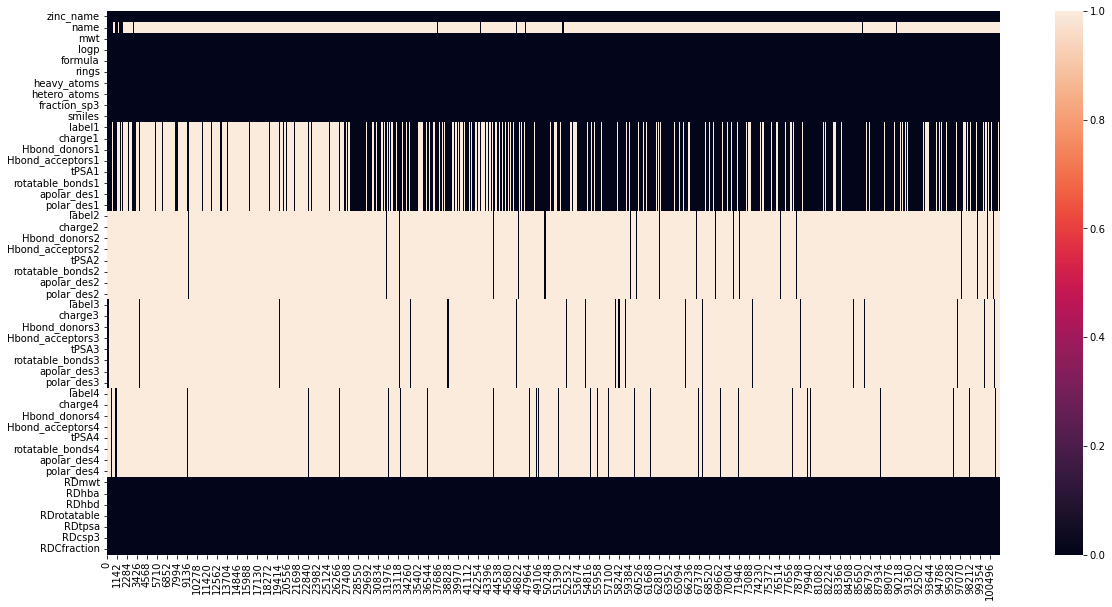

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df_all.isna().transpose(), ax=ax)

The first largely missing feature is _name_ which is the commercial name of drug, and will have no significance for data analysis.  

  However, there is a lot of data missing for additional, pH-dependent parameters (_charge_, _H-bond donors_, _H-bond acceptors_, _tPsa_, _rotatable_bonds_, _apolar_des_, _polar_des_ with extensions _1 (Reference pH)_, _2 (Low pH)_, _3 (Mid pH)_ and _4 (High pH)_). Let's have a closer look at the number of missing data.

In [7]:
pd.read_sql_query("SELECT label1, COUNT(*) as not_null FROM molecules GROUP BY label1", db)

,label1,not_null
0,None,39720
1,Reference,61856


In [8]:
pd.read_sql_query("SELECT label2, COUNT(*) as not_null FROM molecules GROUP BY label2", db)

,label2,not_null
0,None,99466
1,Low pH (6.4),2110


In [9]:
pd.read_sql_query("SELECT label3, COUNT(*) as not_null FROM molecules GROUP BY label3", db)

,label3,not_null
0,None,98026
1,Mid pH (7.4),3550


In [10]:
pd.read_sql_query("SELECT label4, COUNT(*) as not_null FROM molecules GROUP BY label4", db)

,label4,not_null
0,None,97977
1,High pH (8.4),3599


The above numbers are expressed below as percentage and show how many data entries contain information measured at the given pH. <font color='gray'>There are molecules for which pH-dependent data was measured at more than one pH. Note that there are also molecules for which pH-dependent data was not measured at any pH</font>

In [11]:
# percentage of missing data 
pd.read_sql_query("SELECT 100.0*COUNT(label1)/COUNT(*) as label_1,100.0*COUNT(label2)/COUNT(*) as label_2, 100.0*COUNT(label3)/COUNT(*) as label_3, 100.0*COUNT(label4)/COUNT(*) as label_4  FROM molecules", db) 

,label_1,label_2,label_3,label_4
0,60.896275,2.077262,3.49492,3.54316


We can see that pH related parameters measured at Low _(2)_, Mid _(3)_ and High _(4)_ pH were recorded only for marginal number of samples. For this reason all columns related to Low, Mid or High pH will be removed.

Additional parameters measured at the Reference _(1)_ pH are missing for 40% of data. Normally data imputation would be a good approach. However, since the data are missing simultaneously for 8 columns <font color='gray'>(if there is no label "Reference", there is no data recorded at this pH, such as: charge, number of H-bond donors and acceptors, number of rotatable bonds, topologic polar surface area, desolvation free energy (polar and apolar))</font> I chose to keep only the records containing the additional parameters and delete the other rows. So the dataset I will be using is as follows:

In [12]:
df = pd.read_sql_query("SELECT zinc_name, name, mwt, logp, formula, rings, heavy_atoms, hetero_atoms,\
fraction_sp3, smiles, label1, charge1, Hbond_donors1, Hbond_acceptors1, tPSA1, rotatable_bonds1, \
apolar_des1, polar_des1, RDmwt, RDhba, RDhbd, RDrotatable, RDtpsa, RDcsp3, RDCfraction FROM molecules \
WHERE label1 LIKE 'Ref%'", db)

Alternatively, for future project I could keep all the rows but skip the additional parameters measured at the reference pH. Then the dataset would be like this:

In [13]:
df2 = pd.read_sql_query("SELECT zinc_name, name, mwt, logp, formula, rings, heavy_atoms, hetero_atoms,\
fraction_sp3, smiles, RDmwt, RDhba, RDhbd, RDrotatable, RDtpsa, RDcsp3, RDCfraction FROM molecules", db)

Let's go back to the dataset chosen for this project and start by removing the duplicates.

In [14]:
df.shape

(61856, 25)

In [15]:
df.drop_duplicates(inplace=True)
df.shape

(61368, 25)

We got rid of almost 500 duplicates. Let's get more familiar with the dataset.

In [16]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61368 entries, 0 to 61855
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   zinc_name         61368 non-null  object 
 1   name              2045 non-null   object 
 2   mwt               61368 non-null  float64
 3   logp              61368 non-null  float64
 4   formula           61368 non-null  object 
 5   rings             61368 non-null  int64  
 6   heavy_atoms       61368 non-null  int64  
 7   hetero_atoms      61368 non-null  int64  
 8   fraction_sp3      61368 non-null  float64
 9   smiles            61368 non-null  object 
 10  label1            61368 non-null  object 
 11  charge1           61368 non-null  int64  
 12  Hbond_donors1     61368 non-null  int64  
 13  Hbond_acceptors1  61368 non-null  int64  
 14  tPSA1             61368 non-null  float64
 15  rotatable_bonds1  61368 non-null  int64  
 16  apolar_des1       61368 non-null  float6

We can see that <font color='gray'>(after keeping only the data with pH-dependant parameters recorded at the Reference pH)</font> there is no numeric data missing. The missing _name_ and _zinc_names_ have no significance in model building but they will be kept for now as they may be useful to identify molecules during the proces of data cleaning.

In [17]:
pd.set_option('display.max_columns',df.shape[1])

In [18]:
df.describe(include='all')

,zinc_name,name,mwt,logp,formula,rings,heavy_atoms,hetero_atoms,fraction_sp3,smiles,label1,charge1,Hbond_donors1,Hbond_acceptors1,tPSA1,rotatable_bonds1,apolar_des1,polar_des1,RDmwt,RDhba,RDhbd,RDrotatable,RDtpsa,RDcsp3,RDCfraction
count,61368,2045,61368.000000,61368.000000,61368,61368.000000,61368.000000,61368.000000,61368.000000,61368,61368,61368.000000,61368.000000,61368.000000,61368.000000,61368.000000,61368.000000,61368.000000,61368.000000,61368.000000,61368.000000,61368.000000,61368.000000,61368.000000,61368.000000
unique,61368,1898,NaN,NaN,15307,NaN,NaN,NaN,NaN,61368,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ZINC56,(Fenoterol),NaN,NaN,C17H19NO2,NaN,NaN,NaN,NaN,CN1[C@H]2CC[C@@H]1CC(OC(=O)[C@H](CO)c1ccccc1)C2,Reference,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,4,NaN,NaN,104,NaN,NaN,NaN,NaN,1,61368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,284.858536,2.908074,NaN,2.503031,19.854468,5.166944,0.248915,NaN,NaN,-0.057147,0.849987,3.702891,56.755703,3.081329,6.906689,-17.869474,284.475585,3.674912,0.942234,3.082616,56.761628,0.249024,0.735614
std,NaN,NaN,46.822909,1.249200,NaN,0.847502,3.503256,1.622076,0.183597,NaN,NaN,0.426458,0.804774,1.543392,22.570222,1.527309,2.786385,16.164121,46.727379,1.501644,0.827193,1.527682,22.331759,0.183543,0.083007
min,NaN,NaN,102.133000,-2.543000,NaN,0.000000,7.000000,2.000000,0.000000,NaN,NaN,-3.000000,0.000000,0.000000,0.000000,0.000000,-7.760000,-234.930000,102.068080,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
25%,NaN,NaN,254.288250,2.108000,NaN,2.000000,18.000000,4.000000,0.110000,NaN,NaN,0.000000,0.000000,3.000000,40.000000,2.000000,5.200000,-17.130000,254.057909,3.000000,0.000000,2.000000,39.440000,0.111111,0.684211
50%,NaN,NaN,293.373000,3.006000,NaN,2.000000,20.000000,5.000000,0.220000,NaN,NaN,0.000000,1.000000,4.000000,55.000000,3.000000,7.130000,-11.830000,293.105193,4.000000,1.000000,3.000000,55.120000,0.222222,0.750000
75%,NaN,NaN,323.378000,3.793000,NaN,3.000000,23.000000,6.000000,0.360000,NaN,NaN,0.000000,1.000000,5.000000,71.000000,4.000000,8.880000,-9.050000,323.072848,5.000000,1.000000,4.000000,71.060000,0.357143,0.800000


The most important information is that there are **no logP values missing**, and all rows have **reasonable values of logP** because this is our **target value**.

**All variables** have values, which are in a **reasonable range** from a chemical point of view. 

We can see that all rows contain additional parameters recorded at the Reference pH, so we can drop the "label1" column.

In [19]:
df.drop('label1', axis=1, inplace=True)

We can see that for over 60 thousand molecules there are only 15 thousand unique formulas, which means that on average a typical molecule has 4 isomers.

**During data collection some parameters were both scraped directly from the ZINC20 website and generated from SMILES with the use of RDKit. For this reason I would like to start by comparing both to see if they contain the same information:**

#### 1. Compare molecular weight scraped from ZINC20 (mwt column) with the one generated from SMILES with RDKit (RDmwt column)

Since the molecular weight is a continous variable an easy way to check if both values are the same would be to plot one against another.

<AxesSubplot:xlabel='mwt', ylabel='RDmwt'>

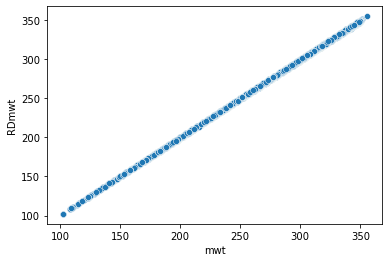

In [20]:
sns.scatterplot(data=df, x='mwt', y='RDmwt')

The data showed a perfect agreement so it doesn't matter which column we'll keep.

In [21]:
df.drop('RDmwt', axis=1, inplace=True)

#### 2. Compare the number of H-bond acceptors scraped from ZINC20 (Hbond_acceptors1 column) with the one generated from SMILES with RDKit (RDhba column)

Let's group the data so we can colour the plot by the number of cases.

In [22]:
hba = pd.read_sql_query("SELECT count(zinc_name) as count, Hbond_acceptors1, RDhba FROM molecules WHERE label1 LIKE 'Ref%' GROUP BY Hbond_acceptors1, RDhba", db)

<AxesSubplot:xlabel='Hbond_acceptors1', ylabel='RDhba'>

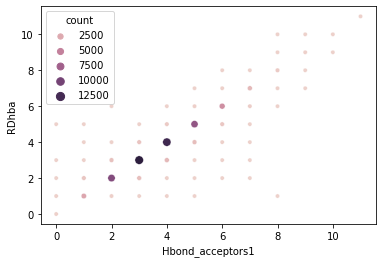

In [23]:
sns.scatterplot(data=hba, x='Hbond_acceptors1', y='RDhba', hue='count', size='count')

Below, the number of cases where both values match (the diagonal cases) are next to the value 1 in the 'equal' column. The off-diagonal cases are next to the 0 in the 'equal' column.

In [24]:
pd.read_sql_query("SELECT count(Hbond_acceptors1), (CASE WHEN Hbond_acceptors1 = RDhba THEN 1 ELSE 0 END) AS equal FROM molecules WHERE label1 LIKE 'Ref%' GROUP BY  equal",db)

,count(Hbond_acceptors1),equal
0,8696,0
1,53160,1


As we can see most of the cases (~86%, group 1) are on the diagonal so for them there is a match between the data scraped directly from ZINC20 and obtained with RDKit. In order to understand the cases where _Hbond_acceptors1_ and _RDhba_ obtained with ZINC20 and RDkit respectively are different (group 2) let's compare the means of some other parameters between group 1 and group 2.

In [25]:
equal = pd.read_sql_query("SELECT Hbond_acceptors1, RDhba, hetero_atoms, fraction_sp3, charge1  FROM molecules WHERE (label1 LIKE 'Ref%') AND Hbond_acceptors1 = RDhba", db)
not_equal = pd.read_sql_query("SELECT Hbond_acceptors1, RDhba, hetero_atoms, fraction_sp3, charge1  FROM molecules WHERE (label1 LIKE 'Ref%') AND Hbond_acceptors1 != RDhba", db)

Below the descriptors <font color=gray>(_Hbond_acceptors1_ and _RDhba_)</font> are equal.

In [26]:
equal.describe().loc[['mean','std']]

,Hbond_acceptors1,RDhba,hetero_atoms,fraction_sp3,charge1
mean,3.697160,3.697160,5.173119,0.238777,-0.019883
std,1.522961,1.522961,1.610668,0.176058,0.193383



Below the descriptors <font color=gray>(_Hbond_acceptors1_ and _RDhba_)</font> are not equal.

In [27]:
not_equal.describe().loc[['mean','std']]

,Hbond_acceptors1,RDhba,hetero_atoms,fraction_sp3,charge1
mean,3.666858,3.469411,5.064972,0.316271,-0.283004
std,1.673591,1.363192,1.700668,0.213309,0.999628


For most descriptors _mean_ and _std_ look similar for both groups except for the _std_ of charge. In order to better understand this difference let's compare  how the charges are distributed in those groups.

[Text(0.5, 1.0, "ZINC20 and RDKit DON'T MATCH")]

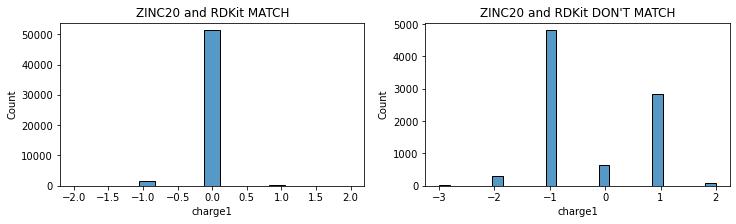

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
sns.histplot(equal, x='charge1', ax=ax1).set(title='ZINC20 and RDKit MATCH') 
sns.histplot(not_equal, x='charge1', ax=ax2).set(title='ZINC20 and RDKit DON\'T MATCH')

We can see that in the case of agreement between the values obtained from ZINC20 and RDKit the moleculas are prevalently neutral and in the case of mismatch only small fraction are neutral molecules. It is probable that RDkit misrepresents ionized molecules as neutral, and thus naturally outputs a different number of H-bond donors/acceptors. For this reason the values which were obtained directly from ZINC20 will be kept.

To be sure, the choice was confirmed by manually counting the number of H-bond acceptors on 10 random molecules, using chemical intuition.

In [29]:
not_equal_names = pd.read_sql_query("SELECT smiles, Hbond_acceptors1, RDhba, charge1, 'https://zinc20.docking.org/substances/' || zinc_name AS link FROM molecules WHERE (label1 LIKE 'Ref%') AND Hbond_acceptors1 != RDhba", db)
not_equal_names.sample(10)

,smiles,Hbond_acceptors1,RDhba,charge1,link
1875,Sc1nnc(COc2ccccc2)n1/N=C/c1c[nH]c2ccccc12,4,6,0,https://zinc20.docking.org/substances/ZINC32492
1496,COc1ccc(-c2cccc(C(=O)O)c2)cc1OC1CCCC1,4,3,-1,https://zinc20.docking.org/substances/ZINC20348
3984,COc1ccc2cc(C(=O)Nc3cccc(C(=O)O)c3)c(=O)oc2c1,6,5,-1,https://zinc20.docking.org/substances/ZINC64297
809,Cc1cn2c(O)c3ncn(COC(CO)CO)c3nc2n1,8,9,0,https://zinc20.docking.org/substances/ZINC5081
5138,NNc1nc(-c2ccccc2Cl)c2cc(Br)ccc2n1,3,4,0,https://zinc20.docking.org/substances/ZINC83418
3964,NC1=N[C@@H](c2ccccc2)N(c2ccccc2Cl)C(N)=N1,1,5,1,https://zinc20.docking.org/substances/ZINC63598
6886,CC(=O)O[C@H]1CCN(Cc2ccco2)[C@@H](C)[C@H]1C,3,4,1,https://zinc20.docking.org/substances/ZINC111486
1747,CC(=O)c1ccc(N2CCNCC2)cc1,2,3,1,https://zinc20.docking.org/substances/ZINC29076
3598,O=C(O)[C@@H]1CNC(=O)N1C(=O)OCc1ccccc1,5,4,-1,https://zinc20.docking.org/substances/ZINC56865
3619,O=C(O)c1cc(F)ccc1C(F)(F)F,2,1,-1,https://zinc20.docking.org/substances/ZINC57043


The box plot below, on the left shows a strong dependence of the number of H-bond acceptors (as determined by ZINC20) on charge. On the other hand, RDkit-derived Hbond acceptor descriptor seem uncorrelated to the charge. This further confirms that ZINC20, unlike RDkit, takes the ionisation state of the molecule into account. 

[Text(0.5, 1.0, 'RDKit')]

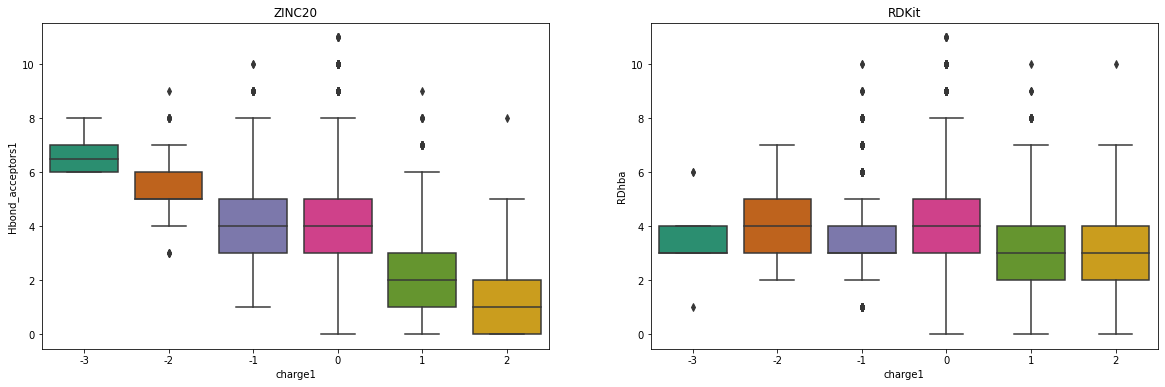

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
sns.boxplot(data=df, y='Hbond_acceptors1', x='charge1', ax=ax1, palette = 'Dark2').set(title='ZINC20') 
sns.boxplot(data=df, y='RDhba', x='charge1', ax=ax2, palette = 'Dark2').set(title='RDKit') 

In [31]:
df.drop('RDhba', axis=1, inplace=True)

#### 3. Compare the number of H-bond donors scraped from ZINC20 (Hbond_donors1 column) with the one generated from SMILES with RDKit (RDhbd column)

Again, let's group the data so we can colour the plot by the number of cases.

In [32]:
hbd = pd.read_sql_query("SELECT count(zinc_name) as count, Hbond_donors1, RDhbd FROM molecules WHERE label1 LIKE 'Ref%' GROUP BY Hbond_donors1, RDhbd", db)

<AxesSubplot:xlabel='Hbond_donors1', ylabel='RDhbd'>

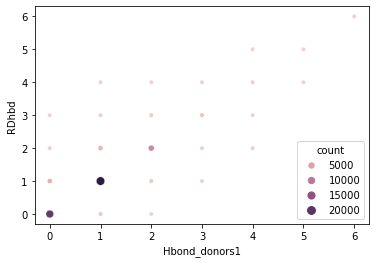

In [33]:
sns.scatterplot(data=hbd, x='Hbond_donors1', y='RDhbd', hue='count', size='count')

Below, the number of cases where both values match (the diagonal cases) are next to the value 1 in the 'equal' column. The off-diagonal cases are next to the 0 in the 'equal' column.

In [34]:
pd.read_sql_query("SELECT count(Hbond_donors1), (CASE WHEN Hbond_donors1 = RDhbd THEN 1 ELSE 0 END) AS equal FROM molecules WHERE label1 LIKE 'Ref%' GROUP BY  equal",db)

,count(Hbond_donors1),equal
0,9101,0
1,52755,1


Similarly to the case of H-bond acceptors, in the case of H-bond donors ~85% molecules are on the diagonal <font color='gray'>(match between the number of H-bond donors scraped directly from ZINC20 and obtained with RDKit, group 1)</font>.
Let's check if for H-bond donors RDKit also fails for charged molecules, like in the case of H-bond acceptors.

In [35]:
equal_hbd = pd.read_sql_query("SELECT Hbond_donors1, RDhbd, hetero_atoms, fraction_sp3, charge1  FROM molecules WHERE (label1 LIKE 'Ref%') AND Hbond_donors1 = RDhbd", db)
not_equal_hbd = pd.read_sql_query("SELECT Hbond_donors1, RDhbd, hetero_atoms, fraction_sp3, charge1  FROM molecules WHERE (label1 LIKE 'Ref%') AND Hbond_donors1 != RDhbd", db)

[Text(0.5, 1.0, "ZINC20 and RDKit DON'T MATCH")]

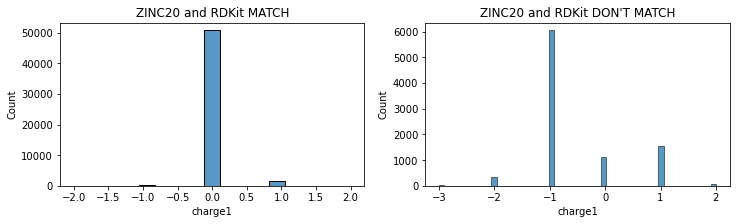

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
sns.histplot(equal_hbd, x='charge1', ax=ax1).set(title='ZINC20 and RDKit MATCH') 
sns.histplot(not_equal_hbd, x='charge1', ax=ax2).set(title='ZINC20 and RDKit DON\'T MATCH')

Like in the case of H-bond acceptors, for H-bond donors the values from ZINC20 differ from the values obtained with RDKit mostly for charged molecules. Again, it is probable that RDkit misrepresents ionized molecules as neutral, and thus naturally outputs a different number of H-bond donors/acceptors. For this reason, again I will keep the values scraped directly from ZINC20

To be sure, the choice was confirmed by manually counting the number of H-bond donors on 10 random molecules below, using chemical intuition.

In [37]:
not_equal_names = pd.read_sql_query("SELECT smiles, Hbond_donors1, RDhbd, charge1, 'https://zinc20.docking.org/substances/' || zinc_name AS link FROM molecules WHERE (label1 LIKE 'Ref%') AND Hbond_donors1 != RDhbd", db)
not_equal_names.sample(10)

,smiles,Hbond_donors1,RDhbd,charge1,link
3538,Cc1cc(=O)oc2cc(O)c(Cl)cc12,0,1,-1,https://zinc20.docking.org/substances/ZINC57901
7628,COc1cc2ncnc(N3CCN(C)CC3)c2cc1OC,1,0,1,https://zinc20.docking.org/substances/ZINC116766
5905,O=C1O[C@@H](C(=O)O)Cc2ccccc21,0,1,-1,https://zinc20.docking.org/substances/ZINC91306
1357,O=P(O)(Nc1ccccc1)Nc1ccccc1,2,3,-1,https://zinc20.docking.org/substances/ZINC28270
2674,O=c1cccc2n1C[C@@H]1C[C@H]2CN2CCCC[C@H]12,1,0,1,https://zinc20.docking.org/substances/ZINC48395
4502,COc1ccc([C@@H](c2c(C)[nH]c3ccccc23)N2CCCCC2)cc1,2,1,1,https://zinc20.docking.org/substances/ZINC72164
4272,COc1cc(NC(=O)[C@@H]2CC(C)=C(C)C[C@H]2C(=O)O)cc...,1,2,-1,https://zinc20.docking.org/substances/ZINC69604
565,O=C1c2cccnc2CN1Cc1ccc(Cl)cc1,1,0,0,https://zinc20.docking.org/substances/ZINC3000
3359,Cc1ccc(-c2ccc(C(=O)O)o2)c([N+](=O)[O-])c1,0,1,-1,https://zinc20.docking.org/substances/ZINC57026
7813,CN(C)CCNC(=O)c1scc2c1CCCC2,2,1,1,https://zinc20.docking.org/substances/ZINC119128


In the box plot below, the number of H-bond donors described by ZINC20 increases with the molecular charge. This is likely due to positive ionisation states having more protons available to donate hydrogen bonds than neutral or negative ionisation states. On the other hand in RDkit-derived descriptors such a monotonic trend is not observed. This suggests that the ionisation state of the molecule is ignored by RDkit and not by ZINC20.

[Text(0.5, 1.0, 'RDKit')]

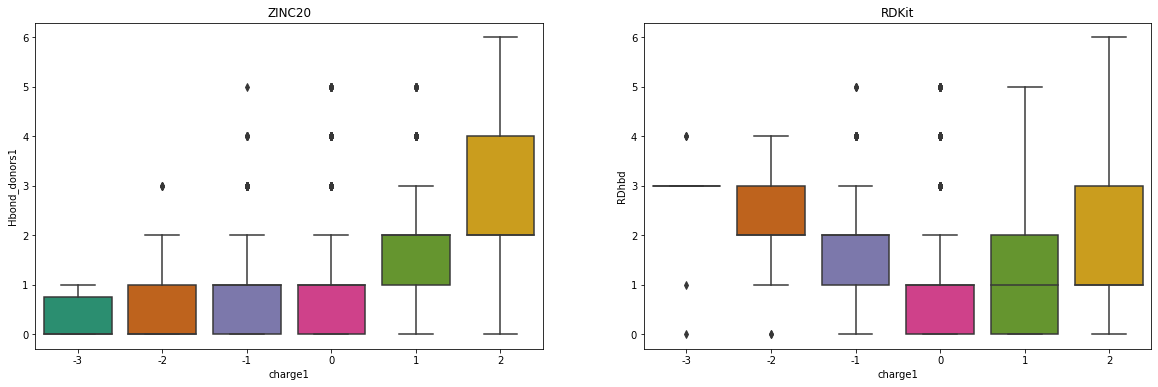

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
sns.boxplot(data=df, y='Hbond_donors1', x='charge1', ax=ax1, palette = 'Dark2').set(title='ZINC20') 
sns.boxplot(data=df, y='RDhbd', x='charge1', ax=ax2, palette = 'Dark2').set(title='RDKit') 

In [39]:
df.drop('RDhbd', axis=1, inplace=True)

#### 4. Compare the number of rotatable bonds scraped from ZINC20 (rotatable bonds1 column) with the one generated from SMILES with RDKit (RDrotatable column)

Again, let's start by grouping the data so we can colour the plot by the number of cases.

In [40]:
rotatable = pd.read_sql_query("SELECT count(zinc_name) as count, rotatable_bonds1, RDrotatable FROM molecules WHERE label1 LIKE 'Ref%' GROUP BY rotatable_bonds1, RDrotatable", db)

<AxesSubplot:xlabel='rotatable_bonds1', ylabel='RDrotatable'>

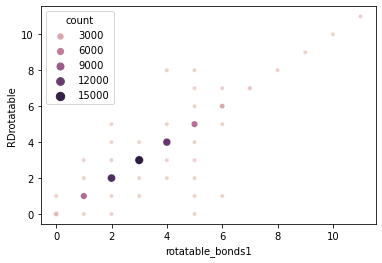

In [41]:
sns.scatterplot(data=rotatable, x='rotatable_bonds1', y='RDrotatable', hue='count', size='count')

Below, the number of cases where both values match (the diagonal cases) are next to the value 1 in the 'equal' column. The off-diagonal cases are next to the 0 in the 'equal' column.

In [42]:
pd.read_sql_query("SELECT count(rotatable_bonds1), (CASE WHEN rotatable_bonds1 = RDrotatable THEN 1 ELSE 0 END) AS equal FROM molecules WHERE label1 LIKE 'Ref%' GROUP BY  equal",db)

,count(rotatable_bonds1),equal
0,273,0
1,61583,1


Here, the correlation is much better than in the previous two cases. The data from ZINC20 database and obtained with RDKit agree in ~ 99.5% of cases. Let's have a look at several of the molecules for which one of the columns has a wrong value.

In [43]:
not_equal_names = pd.read_sql_query("SELECT smiles, rotatable_bonds1, RDrotatable, charge1, 'https://zinc20.docking.org/substances/' || zinc_name AS link FROM molecules WHERE (label1 LIKE 'Ref%') AND rotatable_bonds1 != RDrotatable", db)
not_equal_names.sample(10)

,smiles,rotatable_bonds1,RDrotatable,charge1,link
186,[O-]/[N+](=C\c1ccc(OC(F)F)cc1)c1ccccc1,5,4,1,https://zinc20.docking.org/substances/ZINC84388
84,CC(C)(C)C(=O)C1=C(O)C(=O)N(c2ccccc2)[C@H]1c1cc...,2,3,0,https://zinc20.docking.org/substances/ZINC47168
98,N/C(O)=N/S(=O)(=O)c1ccc(N)cc1,1,2,-1,https://zinc20.docking.org/substances/ZINC53961
62,CCOC(=O)[C@H](C#N)C(=O)c1ccc([N+](=O)[O-])cc1,4,5,-1,https://zinc20.docking.org/substances/ZINC32512
35,Cc1ccc(S(=O)(=O)/N=C(\O)NC2CCCCC2)cc1,2,3,-1,https://zinc20.docking.org/substances/ZINC1514
4,Cc1ccc(Cl)c(OC[C@@H](O)CNC(C)(C)C)c1,4,5,-2,https://zinc20.docking.org/substances/ZINC106
23,CN(C)[C@H]1CCc2[nH]c3c(F)cc(F)cc3c2C1,2,1,-1,https://zinc20.docking.org/substances/ZINC312
20,CN1C[C@@H](CCN2CC=C(c3ccccc3)CC2)OC1=O,3,4,-1,https://zinc20.docking.org/substances/ZINC304
51,CC(C)(C)/[N+]([O-])=C/c1cc(Cl)ccc1O,2,1,1,https://zinc20.docking.org/substances/ZINC8621
189,C/[N+]([O-])=C/c1ccc(C(F)(F)F)cc1,2,1,1,https://zinc20.docking.org/substances/ZINC84687


The analysis of the above cases showed that sometimes ZINC20 was more accurate and sometimes RDKit. The concept of rotatable bond is somewhat arbitrary, especially when resonant structures are involved. It is likely that RDKit and ZINC20 use slightly different rules, which explains the small amounts of inconsistencies. It seems that there is no "superior" choice. Also, the inconsistencies apply to only 0.5 % of the data. So we arbitrarily select the ZINC20 descriptors for the whole dataset.

In [44]:
df.drop('RDrotatable', axis=1, inplace=True)

#### 5. Compare the Topologic Polar Surface Area scraped from ZINC20 (tPSA1 column) with the one generated from SMILES with RDKit (RDtpsa column)

Since the variable is continous, again let's plot one against another.

<AxesSubplot:xlabel='tPSA1', ylabel='RDtpsa'>

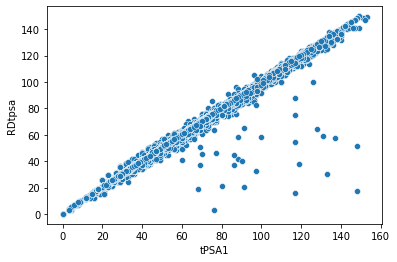

In [45]:
sns.scatterplot(data=df, x='tPSA1', y='RDtpsa')

Based on the figure above we can conclude that for the outliers, either RDKit underestimates the Topologic Polar Surface Area or ZINC20 overestimates it. Let's make an additional column indicating the difference between these two values.

In [46]:
tpsa = df[['zinc_name', 'name','tPSA1','RDtpsa','logp']].copy()
tpsa['difference'] = tpsa['tPSA1'] - tpsa['RDtpsa']
# the link to the molecule on ZINC 20 page
tpsa['link'] = 'https://zinc20.docking.org/substances/' + tpsa['zinc_name']

In [47]:
tpsa.sort_values(by='difference', ascending=False, key=abs, inplace=True)
tpsa.head(10)

,zinc_name,name,tPSA1,RDtpsa,logp,difference,link
61,ZINC116,None,148.0,17.07,2.775,130.93,https://zinc20.docking.org/substances/ZINC116
117,ZINC210,None,133.0,30.49,4.401,102.51,https://zinc20.docking.org/substances/ZINC210
113,ZINC202,(Dazepinil),117.0,15.60,3.966,101.40,https://zinc20.docking.org/substances/ZINC202
53,ZINC103,((S)-Bulbocapnine),148.0,51.16,2.882,96.84,https://zinc20.docking.org/substances/ZINC103
114,ZINC207,(Denzimol),119.0,38.05,3.402,80.95,https://zinc20.docking.org/substances/ZINC207
112,ZINC201,(Dazadrol),137.0,57.51,1.973,79.49,https://zinc20.docking.org/substances/ZINC201
187,ZINC320,(Fluotracen),76.0,3.24,5.644,72.76,https://zinc20.docking.org/substances/ZINC320
62,ZINC118,None,131.0,58.86,3.029,72.14,https://zinc20.docking.org/substances/ZINC118
182,ZINC314,(Flumecinol),91.0,20.23,4.351,70.77,https://zinc20.docking.org/substances/ZINC314
174,ZINC304,(Fenpipalone),97.0,32.78,2.616,64.22,https://zinc20.docking.org/substances/ZINC304


For several named compounds above the literatura data found on PubChem were very similar to those obtained with RDKit. PubChem data are computed with Cactvs: https://www2.chemie.uni-erlangen.de/software/cactvs/tools.html. 

Let's have a closer look at the datapoints where ZINC20 and RDKit disagree.

<AxesSubplot:xlabel='tPSA1', ylabel='RDtpsa'>

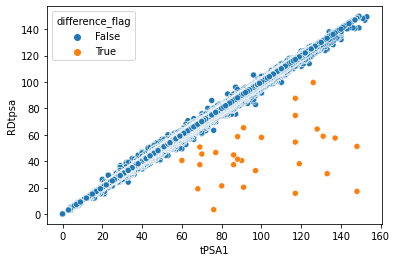

In [48]:
tpsa['difference_flag'] = tpsa['difference'] > 15
sns.scatterplot(data=tpsa, x='tPSA1', y='RDtpsa', hue='difference_flag')

Let's check how the outliers correlate with logP.

In [49]:
from scipy.stats import pearsonr
corr, _ = pearsonr(tpsa[tpsa['difference_flag']==True].tPSA1, tpsa[tpsa['difference_flag']==True].logp)
print('Pearsons correlation of tPSA from ZINC20 with logP calculated for outliers: %.3f' % corr)

Pearsons correlation of tPSA from ZINC20 with logP calculated for outliers: -0.206


In [50]:
corr, _ = pearsonr(tpsa[tpsa['difference_flag']==True].RDtpsa, tpsa[tpsa['difference_flag']==True].logp)
print('Pearsons correlation of tPSA from RDKit with logP as calculated for outliers: %.3f' % corr)

Pearsons correlation of tPSA from RDKit with logP as calculated for outliers: -0.743


<AxesSubplot:title={'center':'RDKit'}, xlabel='RDtpsa', ylabel='logp'>

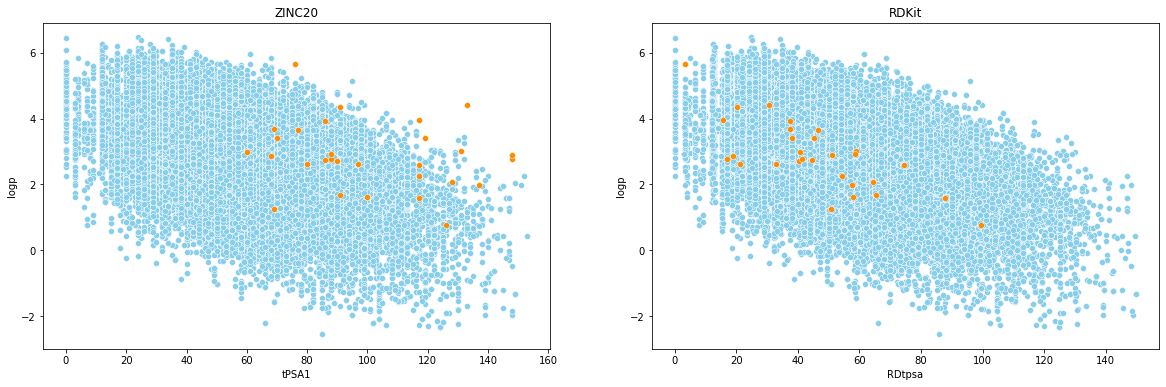

In [51]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
sns.scatterplot(data=tpsa[tpsa['difference_flag']==False], y='logp', x='tPSA1', color='skyblue', ax=ax1, palette = 'pastel').set(title='ZINC20') 
sns.scatterplot(data=tpsa[tpsa['difference_flag']==True], y='logp', x='tPSA1', color='darkorange', ax=ax1, palette = 'Dark2')
sns.scatterplot(data=tpsa[tpsa['difference_flag']==False], y='logp', x='RDtpsa', color='skyblue', ax=ax2, palette = 'Dark2').set(title='RDKit') 
sns.scatterplot(data=tpsa[tpsa['difference_flag']==True], y='logp', x='RDtpsa', color='darkorange', ax=ax2, palette = 'Dark2')

The data aove clearly show that the Topologic Polar Surface Area obtained with RDKit is better correlated with logP (target value) than the data scraped from ZINC20. Also, in the figures it is clear that RDtpsa better follows the trend visible for the remaining data. For this reason _'RDtpsa'_ will be kept for further study.

In [52]:
df.drop('tPSA1', axis=1, inplace=True)

#### 6. Compare the fraction of sp3 hybridized carbons from ZINC20 (fraction_sp3 column) with the one generated from SMILES with RDKit (RDcsp3 column)

Since the variable is continous, again let's plot one against another.

<AxesSubplot:xlabel='fraction_sp3', ylabel='RDcsp3'>

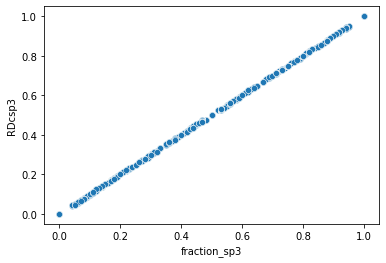

In [53]:
sns.scatterplot(data=df, x='fraction_sp3', y='RDcsp3')

The data showed a perfect agreement so it doesn't matter which one we keep.

In [54]:
df.drop('RDcsp3', axis=1, inplace=True)

#### Final dataset ####

After dealing with all the missing or duplicated data and redundant columns the dataset is ready to be exported. Currently there are following descriptors in the dataset.

In [55]:
df.columns

Index(['zinc_name', 'name', 'mwt', 'logp', 'formula', 'rings', 'heavy_atoms',
       'hetero_atoms', 'fraction_sp3', 'smiles', 'charge1', 'Hbond_donors1',
       'Hbond_acceptors1', 'rotatable_bonds1', 'apolar_des1', 'polar_des1',
       'RDtpsa', 'RDCfraction'],
      dtype='object')

Now, probably we will not need to access the information related to individual molecules any more, so we can remove names of the molecules, SMILES and their formulas. After this, there are 13 descriptors remaining besides the target value.

In [56]:
df.drop(['zinc_name','name','formula','smiles'], axis=1, inplace=True)

In [57]:
df.to_csv('clean_data.csv', index=False)